In [1]:
# imports
import scipy
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import sklearn.neighbors
import sklearn.ensemble
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.pipeline

%matplotlib ipympl
%load_ext autoreload
%autoreload 2

In [2]:
plt.close('all')

# Load and process dataset

In [3]:
dataPath = "./CICIDS2017/"
filesToLoad = os.listdir(dataPath)

dataframes = []
for file in filesToLoad[:1]: # lazy way to limit dataset size
    file_path = os.path.join(dataPath, file)
    df = pd.read_csv(file_path)
    dataframes.append(df)
dataset = pd.concat(dataframes, ignore_index=True)

In [4]:
# drop all rows that contain NaNs
dataset = dataset.replace([np.inf, -np.inf], np.nan)
dataset = dataset.dropna()

In [5]:
dataset.columns

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

In [6]:
# extract labels and change BENIGN to 1 and DDoS to -1. 
# This is SKlearn anomaly detection label convention
labels = dataset[" Label"].copy()
labels.loc[labels != 'BENIGN'] = -1
labels.loc[labels == 'BENIGN'] = 1
labels = labels.astype('int32', copy=False)

In [7]:
features = dataset.drop(" Label", axis=1)

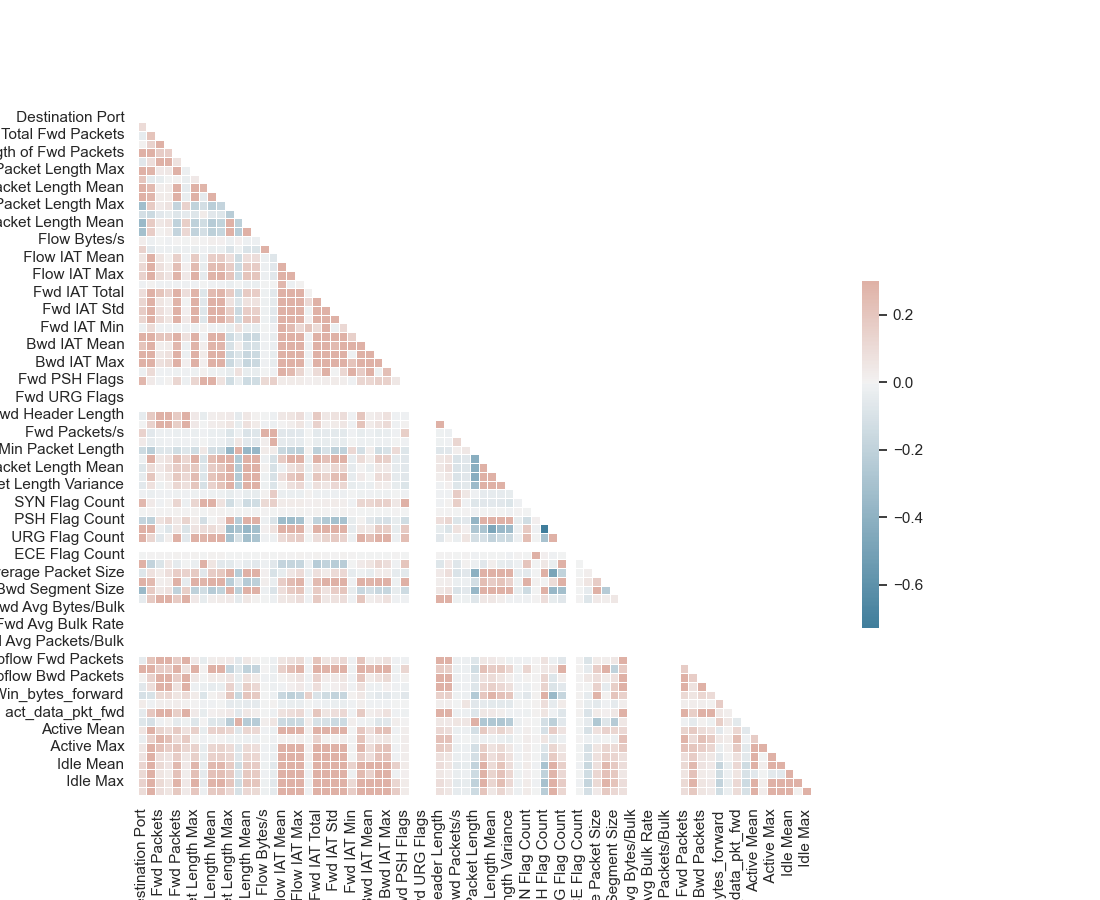

In [8]:
#Feature corelation plot  

sns.set_theme(style="white")
corr = features.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

# train test split

In [9]:
# train validation test split is 70:15:15
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    features, labels, test_size=0.3, random_state=42, stratify=labels, shuffle=True)

X_test, X_valid, y_test, y_valid = sklearn.model_selection.train_test_split(
    X_test, y_test, test_size=0.5, random_state=42, stratify=y_test, shuffle=True)

# unsupervised local outlier factor version

In [11]:
LOF_unsupervised = sklearn.neighbors.LocalOutlierFactor(novelty=False, n_jobs=-1, n_neighbors=50)
LOF_pred1 = LOF_unsupervised.fit_predict(X_train)

sklearn.metrics.f1_score(y_train, LOF_pred1, average='binary')

0.5596295190836846

In [14]:
LOF_unsupervised2 = sklearn.neighbors.LocalOutlierFactor(novelty=True, n_jobs=-1, n_neighbors=50)
LOF_unsupervised2.fit(X_train)

sklearn.metrics.f1_score(y_valid, LOF_unsupervised2.predict(X_valid), average='binary')

c:\Users\Mati\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


0.5581243326869021

# Semi supervised

In [ ]:
LOF_semi = sklearn.neighbors.LocalOutlierFactor(novelty=True, n_jobs=-1, n_neighbors=50)
mask = (y_train == 1)
LOF_semi.fit(X_train[mask])

sklearn.metrics.f1_score(y_valid, LOF_semi.predict(X_valid), average='binary')

c:\Users\Mati\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


0.7957744328763776

# Supervised

In [19]:
nbrs = sklearn.neighbors.KNeighborsClassifier(n_neighbors=3)
nbrs.fit(X_train, y_train)

sklearn.metrics.f1_score(y_valid, nbrs.predict(X_valid), average='binary')

0.9975750537928209